In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ipywidgets
from ipywidgets import interact

import sys
sys.path.append("../")

import datapipe
from datapipe.io.images import image_files_in_dir
from datapipe.denoising.wavelets_mrtransform import wavelet_transform

In [2]:
from datapipe.denoising.inverse_transform_sampling import EmpiricalDistribution
import datapipe.denoising.cdf

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// see https://github.com/ipython/ipython/issues/2172

<IPython.core.display.Javascript object>

In [4]:
np.set_printoptions(threshold=np.inf)

## Display input fits files

In [5]:
#DIR_PATH = "/Users/jdecock/data/astri_mini_array_konrad/fits/astri_v2/gamma/"
#DIR_PATH = "/Users/jdecock/data/gct_mini_array_konrad/fits/gct/gamma/"
DIR_PATH = "/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/"
#DIR_PATH = "/Users/jdecock/data/astri_mini_array/fits/flashcam/gamma/"
#DIR_PATH = "/Users/jdecock/data/grid_prod3b_north/fits/nectarcam/gamma/"
#DIR_PATH = "/Users/jdecock/data/grid_prod3b_north/fits/lst/gamma/"

file_path_list = list(image_files_in_dir(DIR_PATH, max_num_files=5))
file_path_list

['/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz_TEL001_EV00109.fits',
 '/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz_TEL001_EV02301.fits',
 '/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz_TEL001_EV02308.fits',
 '/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz_TEL001_EV02607.fits',
 '/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-dc_desert-2150m-Paranal-sst-dc.simtel.gz_TEL001_EV02802.fits']

In [7]:
IMG_SIZE = 7

def plot(data_list, title_list="", log=False):
    num_imgs = len(data_list)
    
    fig, ax_list = plt.subplots(ncols=num_imgs, figsize=(num_imgs*IMG_SIZE, IMG_SIZE), squeeze=True)
    
    for data, title, ax in zip(data_list, title_list, ax_list):
        ax.set_title(title)

        if log:
            # See http://matplotlib.org/examples/pylab_examples/pcolor_log.html
            #     http://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw
            #im = ax1.pcolor(x, y, image_array, norm=LogNorm(vmin=0.01, vmax=image_array.max()), cmap=self.color_map)  # TODO: "vmin=0.01" is an arbitrary choice...
            im = ax.imshow(data, interpolation='nearest', origin='lower', norm=LogNorm(vmin=0.01, vmax=data.max()), cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
        else:
            im = ax.imshow(data, interpolation='nearest', origin='lower', cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
            #im = ax1.pcolor(x, y, image_array, cmap=self.color_map, vmin=z_min, vmax=z_max)

        plt.colorbar(im, ax=ax)  # draw the colorbar

        #ax2 = fig.add_subplot(212)
        #ax2.hist(data)
    
    plt.show()


def plot_hist(data_list, title_list="", log=True):
    num_imgs = len(data_list)
    
    fig, ax_list = plt.subplots(ncols=num_imgs, figsize=(num_imgs*IMG_SIZE, IMG_SIZE), squeeze=True)
    
    for data, title, ax in zip(data_list, title_list, ax_list):
        ax.set_title(title)
        
        nan_mask = np.isnan(data)

        ax.hist(data[np.logical_not(nan_mask)], log=log)
    
    plt.show()

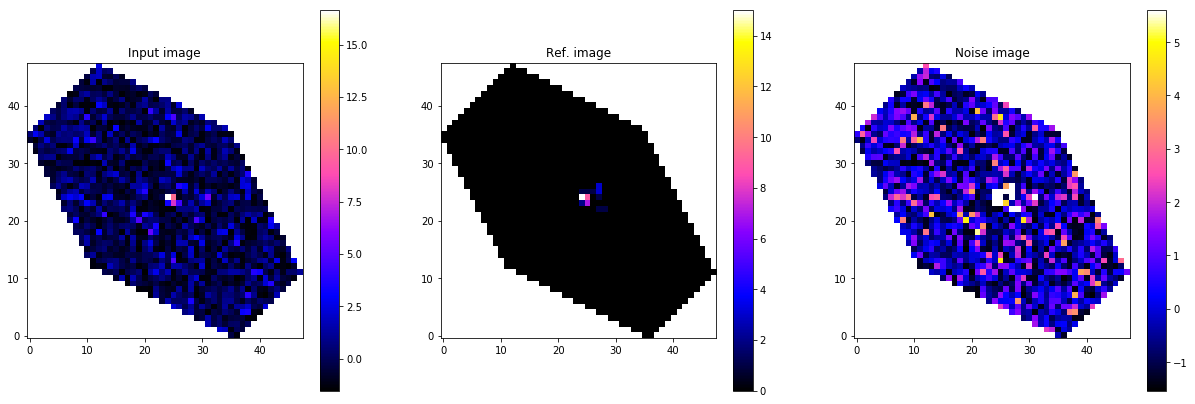

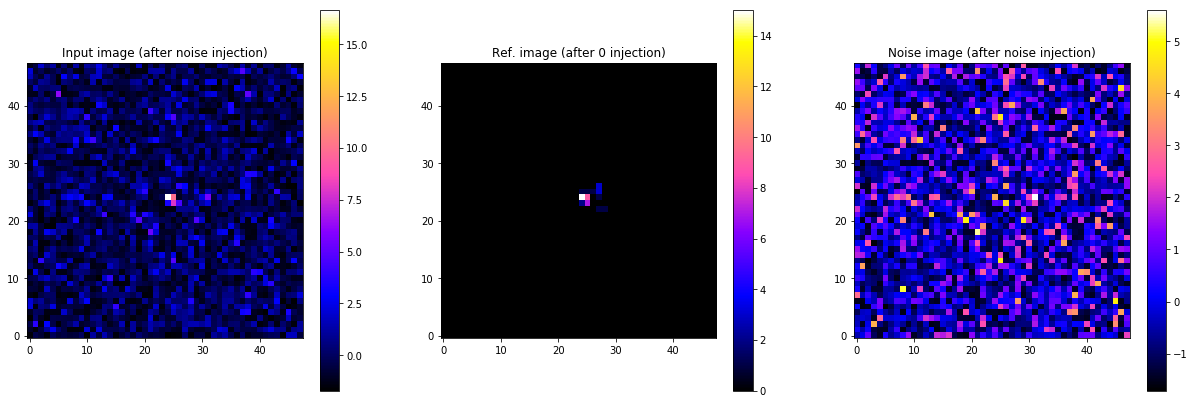

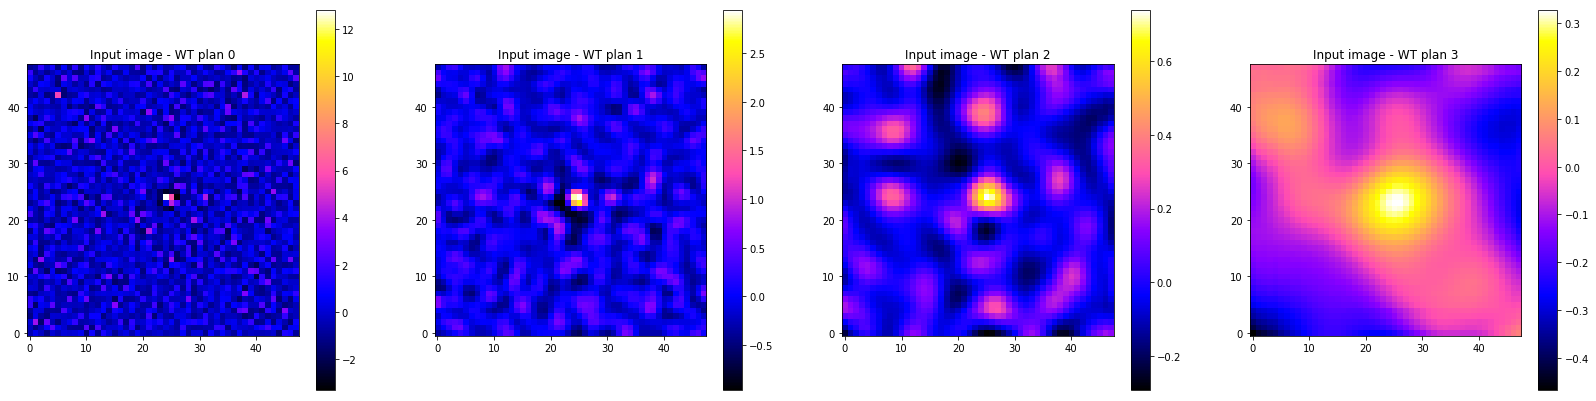

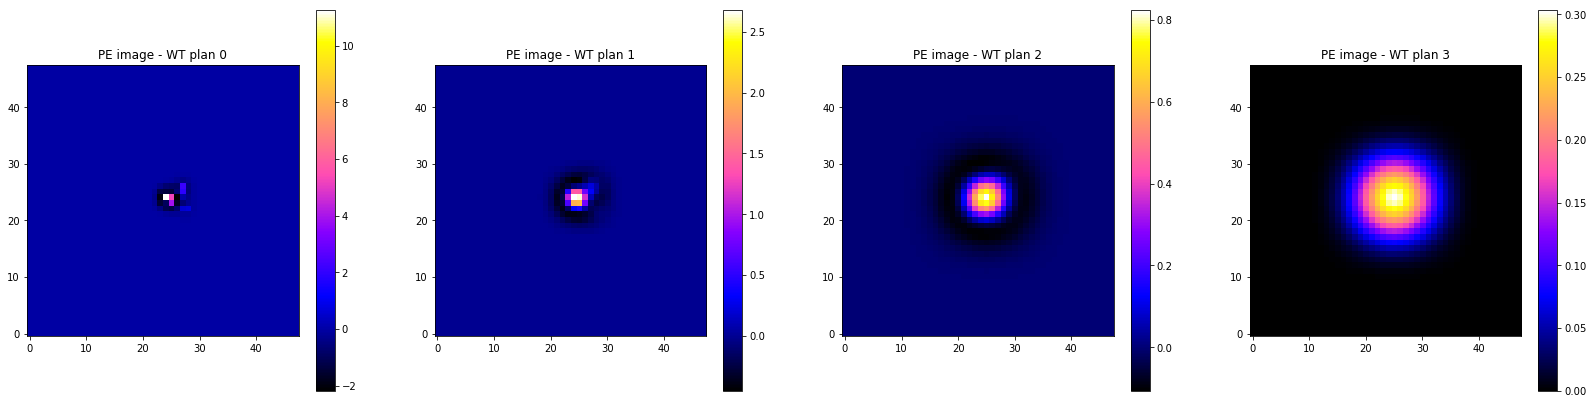

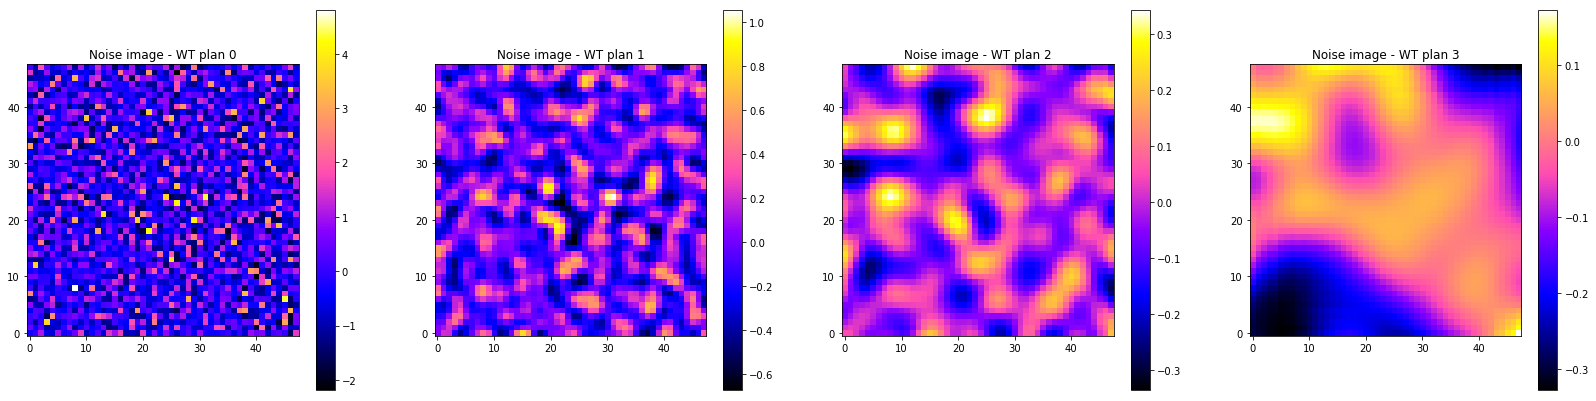

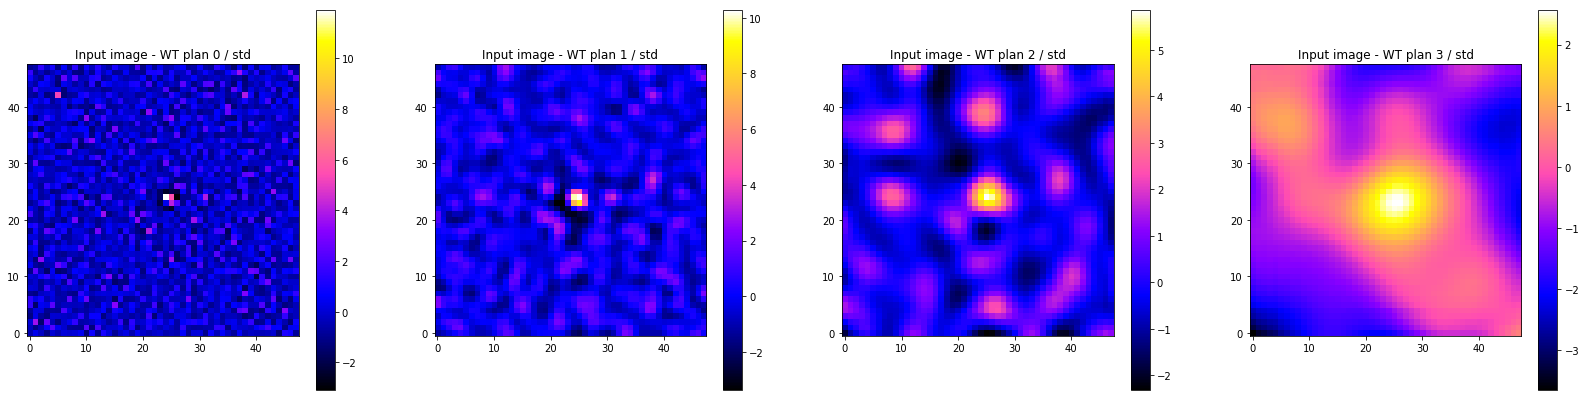

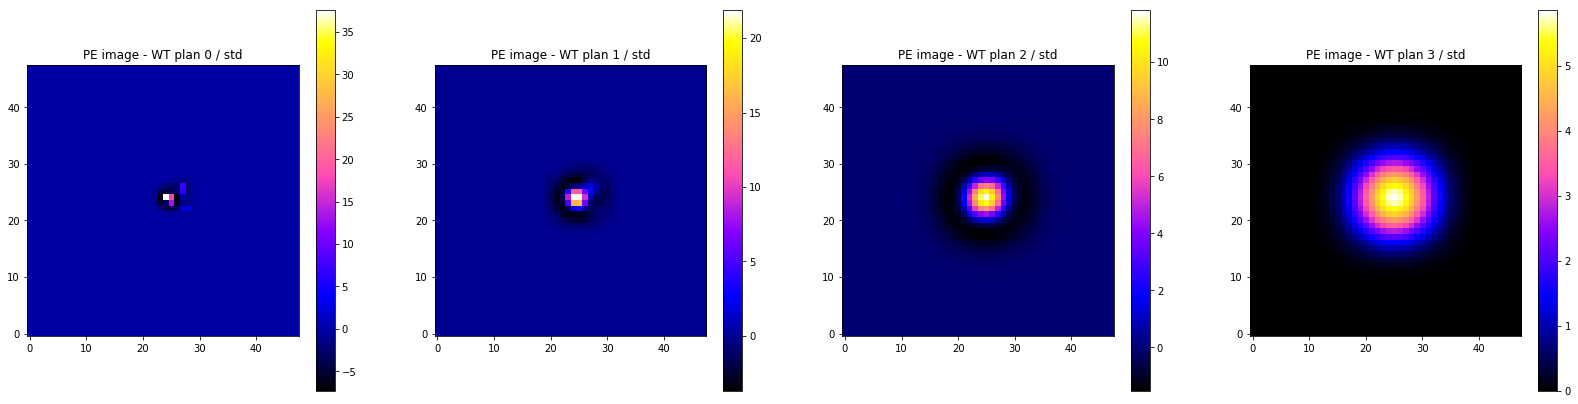

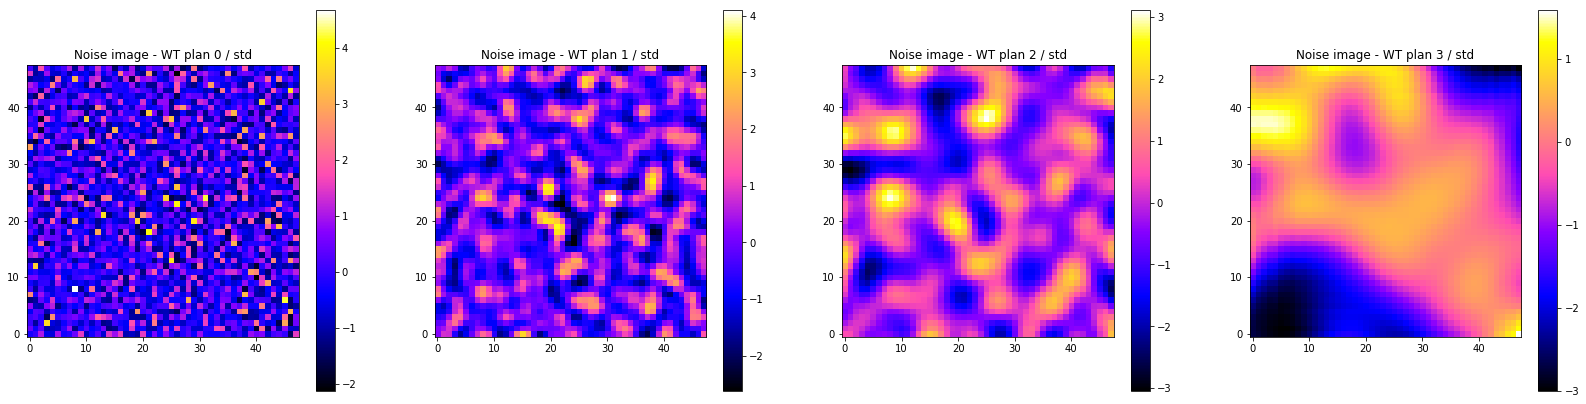

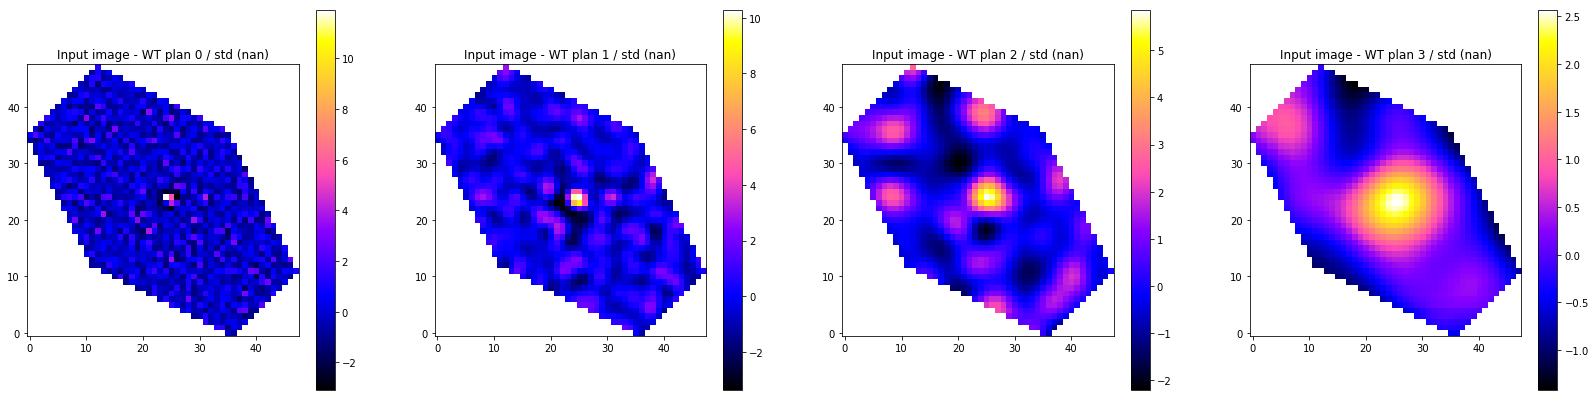

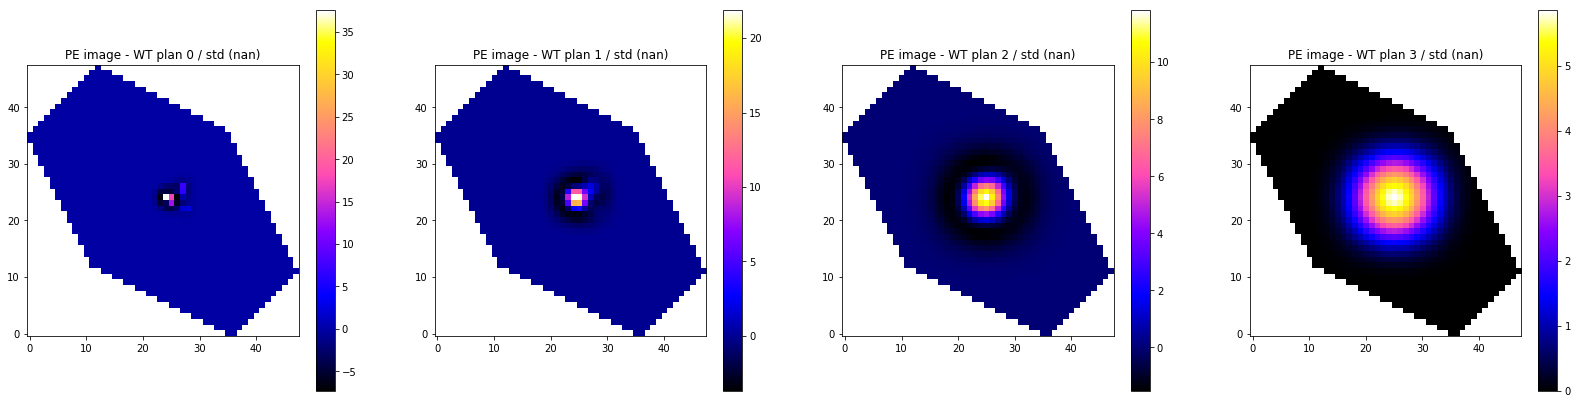

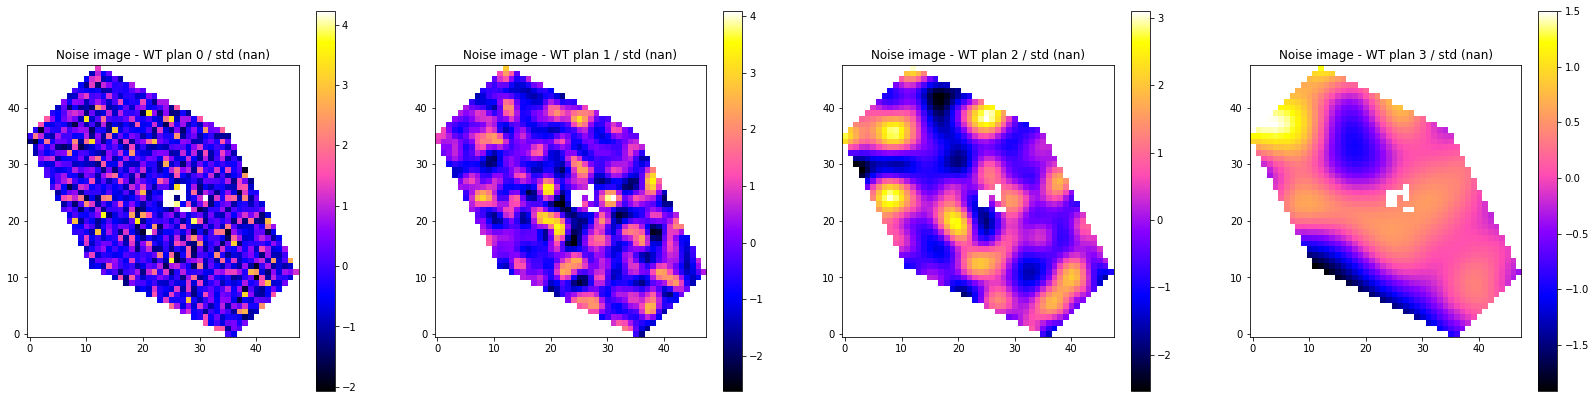

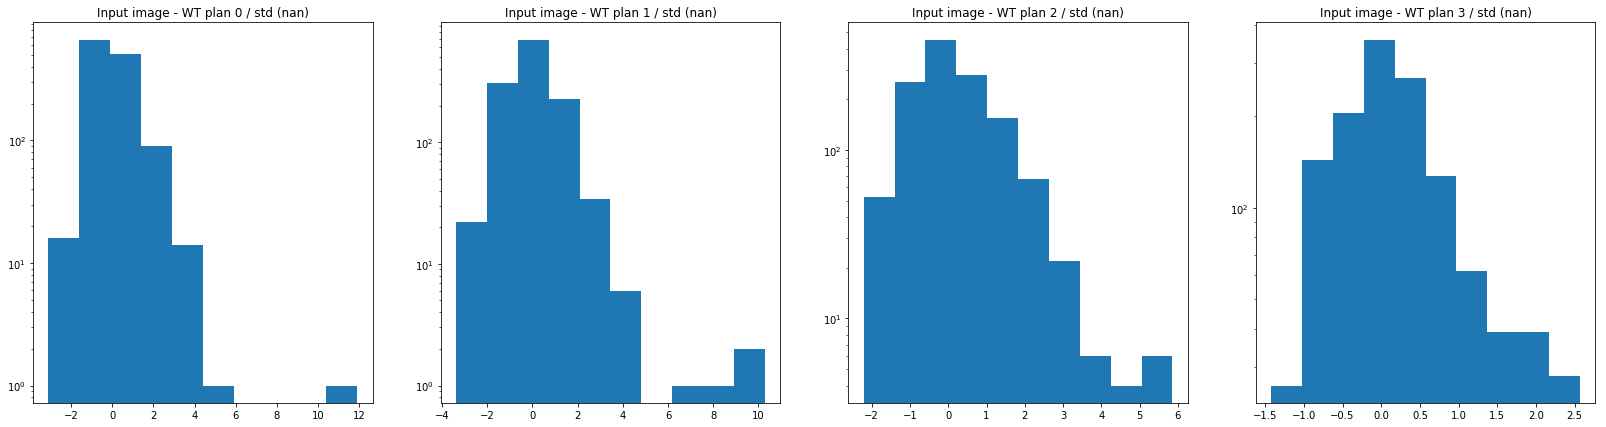

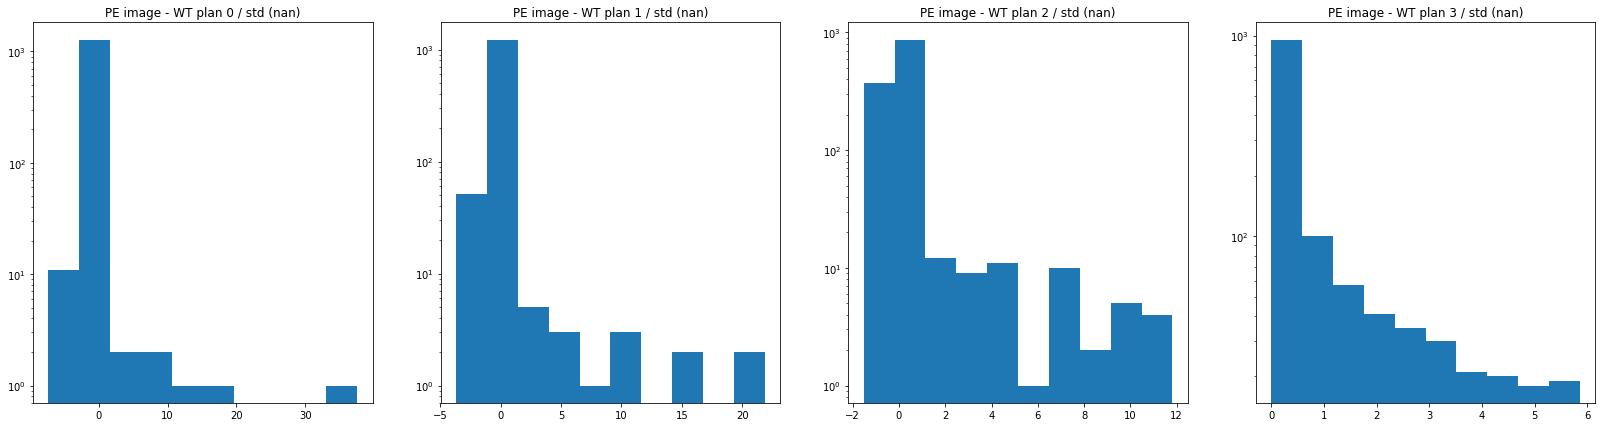

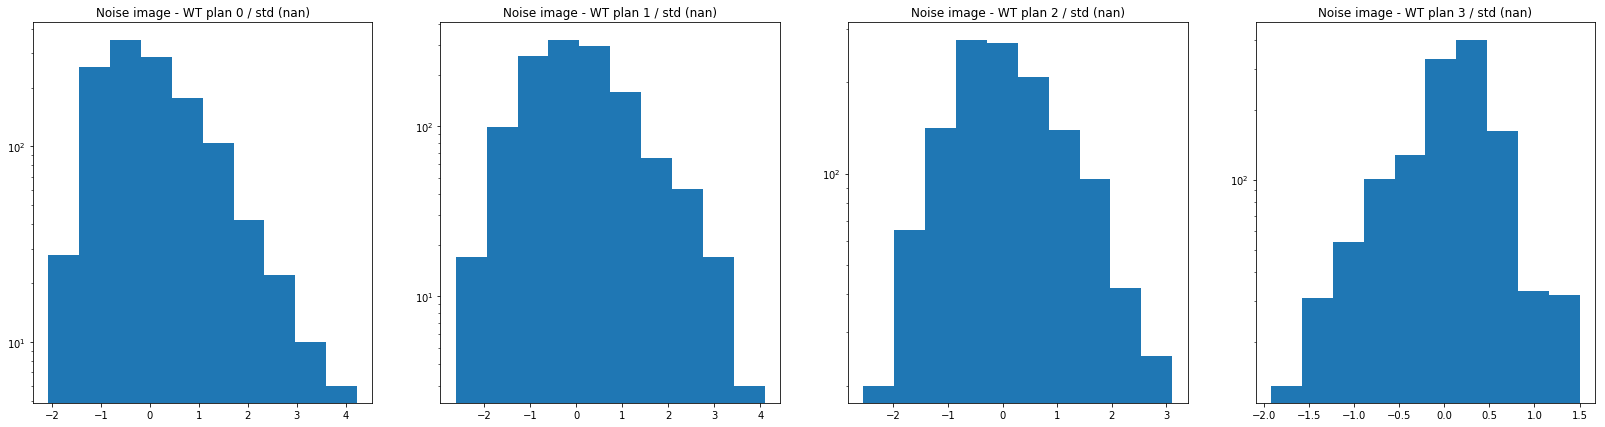

In [8]:
@interact(file_path=file_path_list)
def gui(file_path, noise_injection=True):
    images, metadata = datapipe.io.images.load_benchmark_images(file_path)
    
    # Make ref, input and noise images #################
    
    in_img = np.copy(images["input_image"])
    ref_img = np.copy(images["reference_image"])
    
    noise_img = np.copy(in_img)
    noise_img[ref_img != 0.] = np.nan
    
    plot([in_img, ref_img, noise_img],
         title_list=["Input image", "Ref. image", "Noise image"])
    
    # Inject noise in NaN pixels #######################

    in_nan_mask = np.isnan(in_img)
    ref_nan_mask = np.isnan(ref_img)
    noise_nan_mask = np.isnan(noise_img)
    
    if noise_injection:
        if metadata['cam_id'] == 'ASTRI':
            dist = EmpiricalDistribution(datapipe.denoising.cdf.ASTRI_CDF_FILE)
            
        elif metadata['cam_id'] in ('GATE', 'CHEC'):
            dist = EmpiricalDistribution(datapipe.denoising.cdf.GCT_CDF_FILE)
            
        elif metadata['cam_id'] == 'DigiCam':
            dist = EmpiricalDistribution(datapipe.denoising.cdf.DIGICAM_CDF_FILE)
            
        elif metadata['cam_id'] == 'FlashCam':
            dist = EmpiricalDistribution(datapipe.denoising.cdf.FLASHCAM_CDF_FILE)
            
        elif metadata['cam_id'] == 'NectarCam':
            dist = EmpiricalDistribution(datapipe.denoising.cdf.NECTARCAM_CDF_FILE)
            
        elif metadata['cam_id'] == 'LSTCam':
            dist = EmpiricalDistribution(datapipe.denoising.cdf.LSTCAM_CDF_FILE)
            
        else:
            raise ValueError("Wrong cam_id", metadata['cam_id'])

        in_img[in_nan_mask] = dist.rvs(size=np.count_nonzero(in_nan_mask))
        
        ref_img[ref_nan_mask] = 0.

        noise_img[noise_nan_mask] = dist.rvs(size=np.count_nonzero(noise_nan_mask))

        plot([in_img, ref_img, noise_img],
             title_list=["Input image (after noise injection)", "Ref. image (after 0 injection)", "Noise image (after noise injection)"])
    
    # Apply Wavelet transform ##########################
    
    in_plan_imgs = wavelet_transform(in_img)
    ref_plan_imgs = wavelet_transform(ref_img)
    noise_plan_imgs = wavelet_transform(noise_img)
    
    plot(in_plan_imgs,
         title_list=["Input image - WT plan {}".format(i) for i in range(len(in_plan_imgs))])
    
    plot(ref_plan_imgs,
         title_list=["PE image - WT plan {}".format(i) for i in range(len(ref_plan_imgs))])
            
    plot(noise_plan_imgs,
         title_list=["Noise image - WT plan {}".format(i) for i in range(len(noise_plan_imgs))])

    # "Normalize plans" ################################
    
    for plan in in_plan_imgs:
        std = plan.std()
        plan /= std
    
    for plan in ref_plan_imgs:
        std = plan.std()
        plan /= std
    
    for plan in noise_plan_imgs:
        std = plan.std()
        plan /= std
    
    plot(in_plan_imgs,
         title_list=["Input image - WT plan {} / std".format(i) for i in range(len(in_plan_imgs))])
    
    plot(ref_plan_imgs,
         title_list=["PE image - WT plan {} / std".format(i) for i in range(len(ref_plan_imgs))])
            
    plot(noise_plan_imgs,
         title_list=["Noise image - WT plan {} / std".format(i) for i in range(len(noise_plan_imgs))])
    
    # Filter NaN pixels ################################
    
    for plan in in_plan_imgs:
        plan[in_nan_mask] = np.nan
    
    for plan in ref_plan_imgs:
        plan[ref_nan_mask] = np.nan
    
    for plan in noise_plan_imgs:
        plan[noise_nan_mask] = np.nan
    
    plot(in_plan_imgs,
         title_list=["Input image - WT plan {} / std (nan)".format(i) for i in range(len(in_plan_imgs))])
    
    plot(ref_plan_imgs,
         title_list=["PE image - WT plan {} / std (nan)".format(i) for i in range(len(ref_plan_imgs))])
            
    plot(noise_plan_imgs,
         title_list=["Noise image - WT plan {} / std (nan)".format(i) for i in range(len(noise_plan_imgs))])
    
    # Histograms #######################################
    
    plot_hist(in_plan_imgs,
              title_list=["Input image - WT plan {} / std (nan)".format(i) for i in range(len(in_plan_imgs))])
    
    plot_hist(ref_plan_imgs,
              title_list=["PE image - WT plan {} / std (nan)".format(i) for i in range(len(ref_plan_imgs))])
            
    plot_hist(noise_plan_imgs,
              title_list=["Noise image - WT plan {} / std (nan)".format(i) for i in range(len(noise_plan_imgs))])